In [ ]:
import numpy as np
import xarray as xr
import glob

#INPUT
year='2005'
month='01'
#PATH CONF
ROOTEN = "/home5/pharos/REFERENCE_DATA/OCEAN_REP/EN4/DATA/G10/PROFILES/" 
ROOTOC = "/export/home1/MOUNTS/OCCIPUT/OBS/"
pathen = glob.glob(ROOTEN+year+'/EN.4.2.0.f.profiles.g10.'+year+month+'.nc')
pathoc = glob.glob(ROOTOC+'OBS.y'+year+'m'+month+'/ORCA025.L75-OCCITENS.*_enact_fdbk.nc')
#SORT PATH SO N_MEMBER = 1:50
pathoc.sort()

#SUBSELECT DEF
def subselect_en4(ds):    
    ds = ds.where((ds.WMO_INST_TYPE.isin([' 831',])) 
              & (ds.LATITUDE.values > 20) & (ds.LATITUDE.values < 45)
              & (ds.LONGITUDE.values > -85) & (ds.LONGITUDE.values < -30)
              ,drop=True)
    return ds

def subselect_region(ds):
    ds = ds.where((ds.STATION_TYPE.isin([' 831',])) 
              & (ds.LATITUDE.values > 20) & (ds.LATITUDE.values < 45)
              & (ds.LONGITUDE.values > -85) & (ds.LONGITUDE.values < -30)
              ,drop=True)
    return ds
def subselect_qc(dsub):
    mask = (np.abs(dsub['POTM_OBS']) != dsub['POTM_OBS']._Fillvalue) \
            & (dsub['POTM_Hx'] != dsub['POTM_Hx']._Fillvalue) \
            & (np.abs(dsub['PSAL_OBS']) != dsub['PSAL_OBS']._Fillvalue) \
            & (dsub['PSAL_Hx'] != dsub['PSAL_Hx']._Fillvalue) \
            & (dsub['POSITION_QC'] == 1.) \
            & (dsub['DEPTH_QC'] == 1.) \
            & (dsub['PSAL_LEVEL_QC'] == 1.) \
            & (dsub['POTM_LEVEL_QC'] == 1.)
    dsub.coords['mask'] = (('N_OBS', 'N_LEVELS'), mask)    
    dsub = dsub.where(dsub.mask >= 1, drop=True)
    dsub = dsub.drop('mask')
    return dsub

def subselect_occ(ds):    
    ds = subselect_region(ds)
    ds = subselect_qc(ds)
    return ds

#OPEN
EN4=xr.open_mfdataset(pathen,concat_dim='N_PROF',decode_times=False,preprocess=subselect_en4,mask_and_scale=True)
OCC=xr.open_mfdataset(pathoc,concat_dim='N_MEMBER',decode_times=False,preprocess=subselect_occ,mask_and_scale=True)

#CORRECT Q PREFIX FOR OCCIPUT ARGO WMO
idq=[i for i,item in enumerate(OCC.STATION_IDENTIFIER[0,:].values) if "Q" in item]
for k in idq:
    aa=str(OCC.STATION_IDENTIFIER[0,k].values)     
    if aa not in ['Q6901162','Q4901722','Q4902132','Q4902258',
                  'Q4902133','Q4902131','Q6901162','Q4902261',
                  'Q4902262','Q4902258','Q6901160','Q6901161']:
        OCC.STATION_IDENTIFIER.load()
        OCC.STATION_IDENTIFIER[:,k]=aa[1:]+' '
        
#useless variables
OCC=OCC.drop(['VARIABLES','ENTRIES','EXTRA'])
        
# Redundant information through the N_MEMBER dimension:
#vlist = ['DEPTH_QC', 'DEPTH_QC_FLAGS','JULD_REFERENCE', 'OBSERVATION_QC', 'OBSERVATION_QC_FLAGS',
#         'POSITION_QC', 'POSITION_QC_FLAGS', 'JULD_QC', 'JULD_QC_FLAGS',
#         'ORIGINAL_FILE_INDEX', 'LATITUDE', 'LONGITUDE', 'JULD',
#         'STATION_IDENTIFIER', 'STATION_TYPE', 'DEPTH','POTM_OBS',
#         'POTM_LEVEL_QC','PSAL_OBS','PSAL_LEVEL_QC','TEMP','POTM_QC']
#for v in vlist:
#    OCC[v] = OCC[v].isel(N_MEMBER=0)
      
# Redundant information through the N_LEVELS dimension:
#vlist = ['STATION_IDENTIFIER','JULD','STATION_TYPE','LATITUDE','LONGITUDE','JULD_QC']
#for v in vlist:
#    OCC[v] = OCC[v].isel(N_LEVELS=0)
        
#LIGHTER EN4 MATCHING DATE LOOKUP ARRAY
EN4sl=xr.DataArray(EN4.PLATFORM_NUMBER.values, coords=[('JULD', EN4.JULD.values)], dims=['JULD']);
#LOOKUP ARRAY
#EN4sf= xr.Dataset({'WMO': (['JULD'],  EN4.PLATFORM_NUMBER),
#                'LATITUDE': (['JULD'], EN4.LATITUDE),
#                'LONGITUDE': (['JULD'], EN4.LONGITUDE),
#                'TEMP': (['JULD','N_LEVELS'], EN4.TEMP),
#                'POTM': (['JULD','N_LEVELS'], EN4.POTM_CORRECTED),   
#                'POTM_QC': (['JULD','N_LEVELS'], EN4.POTM_CORRECTED_QC),      
#                'PSAL': (['JULD','N_LEVELS'], EN4.PSAL_CORRECTED),
#                'PSAL_QC': (['JULD','N_LEVELS'], EN4.PSAL_CORRECTED_QC),   
#                'DEPTH': (['JULD','N_LEVELS'], EN4.DEPH_CORRECTED),                
#                },
#                 coords={'JULD': EN4.JULD.values})

<IPython.core.display.Javascript object>


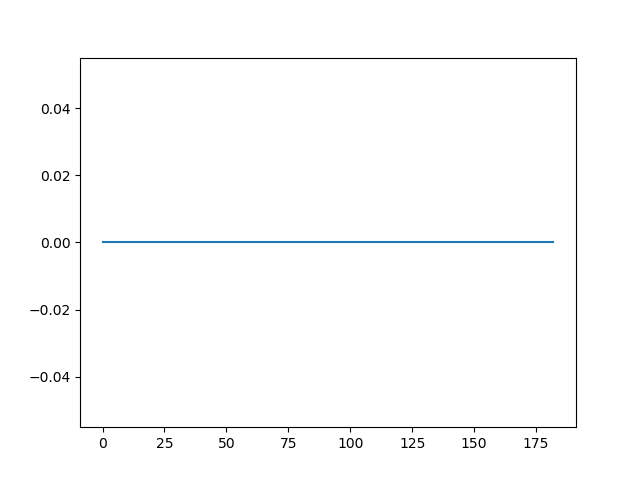

In [20]:
plt.plot(OCC.N_OBS,np.isnan(OCC.JULD[0,:]))

In [10]:
#INIT FINAL DATASET
fds= xr.Dataset({'STATION_IDENTIFIER': (['N_OBS'],  OCC.STATION_IDENTIFIER),
                 'LATITUDE': (['N_OBS'],  OCC.LATITUDE), 
                 'LONGITUDE': (['N_OBS'],  OCC.LONGITUDE), 
                 'JULD': (['N_OBS'],  OCC.JULD*np.nan), 
                 'DEPTH': (['N_OBS','N_LEVELS'],  OCC.DEPTH),                 
                 'POTM_OBS': (['N_OBS','N_LEVELS'],  OCC.POTM_OBS),
                 'POTM_QC': (['N_OBS','N_LEVELS'],  OCC.POTM_LEVEL_QC.astype('int8')),
                 'POTM_Hx': (['N_MEMBER','N_OBS','N_LEVELS'],  OCC.POTM_Hx),
                 'PSAL_OBS': (['N_OBS','N_LEVELS'],  OCC.PSAL_OBS),
                 'PSAL_QC': (['N_OBS','N_LEVELS'],  OCC.PSAL_LEVEL_QC.astype('int8')),
                 'PSAL_Hx': (['N_MEMBER','N_OBS','N_LEVELS'],  OCC.PSAL_Hx),
                 'TEMP_OBS': (['N_OBS','N_LEVELS'],  OCC.TEMP),                 
                 'MATCH_EN4': (['N_OBS'], np.full((len(OCC.JULD)), np.nan,dtype='int8')), 
                })

fds.JULD.attrs['_FillValue']=99999.0
fds.JULD.attrs['long_name']='Julian date of observation (from EN4)'
fds.LATITUDE.attrs['_FillValue']=99999.0
fds.LATITUDE.attrs['long_name']='Latitude of observation'
fds.LONGITUDE.attrs['_FillValue']=99999.0
fds.LONGITUDE.attrs['long_name']='Longitude of observation'
fds.DEPTH.attrs['_FillValue']=99999.0
fds.DEPTH.attrs['long_name']='Depth of observation from OCCIPUT'
fds.POTM_OBS.attrs['_FillValue']=99999.0
fds.POTM_OBS.attrs['long_name']='Potential temperature of observation from OCCIPUT'
fds.POTM_Hx.attrs['_FillValue']=99999.0
fds.POTM_Hx.attrs['long_name']='Model interpolated potential temperature'
fds.PSAL_OBS.attrs['_FillValue']=99999.0
fds.PSAL_OBS.attrs['long_name']='Practical salinity of observation from OCCIPUT'
fds.PSAL_Hx.attrs['_FillValue']=99999.0
fds.PSAL_Hx.attrs['long_name']='Model interpolated practical salinity'
fds.POTM_QC.attrs['_FillValue']=0
fds.POTM_QC.attrs['long_name']='Quality for each level on potential temperature from OCCIPUT'
fds.PSAL_QC.attrs['_FillValue']=0
fds.PSAL_QC.attrs['long_name']='Quality for each level on practical salinity from OCCIPUT'
fds.TEMP_OBS.attrs['_FillValue']=99999.0
fds.TEMP_OBS.attrs['long_name']='Temperature of observation from OCCIPUT'
print fds

<xarray.Dataset>
Dimensions:             (N_LEVELS: 400, N_LEVELS_EN4: 400, N_MEMBER: 50, N_OBS: 532)
Dimensions without coordinates: N_LEVELS, N_LEVELS_EN4, N_MEMBER, N_OBS
Data variables:
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float32 28.586468 ...
    JULD                (N_OBS) float64 2.359e+04 2.359e+04 2.359e+04 ...
    PSAL_QC             (N_OBS, N_LEVELS) int8 1 1 1 1 1 97 97 97 97 97 97 ...
    PSAL_EN4            (N_OBS, N_LEVELS_EN4) float64 nan nan nan nan nan ...
    DEPTH               (N_OBS, N_LEVELS) float64 5.963 10.63 15.6 20.67 ...
    STATION_IDENTIFIER  (N_OBS) object '4901535 ' '4901622 ' '5903892 ' ...
    LATITUDE_EN4        (N_OBS) float64 nan nan nan nan nan nan nan nan nan ...
    PSAL_OBS            (N_OBS, N_LEVELS) float32 36.415 36.414 36.414 ...
    JULD_EN4            (N_OBS) float64 nan nan nan nan nan nan nan nan nan ...
    DEPTH_EN4           (N_OBS, N_LEVELS_EN4) float64 nan nan nan nan nan ...
    POTM_EN4            (N_OBS, N_LEVEL

In [19]:
# MATCH
tolerance=1.0 #in days
for i in range(0,len(OCC.STATION_IDENTIFIER)):          
    ac=EN4sl.where(EN4sl.isin([OCC.STATION_IDENTIFIER[i].values]),drop=True)    
    ac=ac.sortby(ac.JULD)
    #print i,len(ac.JULD)
    if len(ac.JULD)>0:# wmo match found                
        bc=ac.sel(JULD=[OCC.JULD[i].values],method='nearest')
        if(abs(bc.JULD.values-OCC.JULD[i].values)<tolerance): #date match into tolerance
            #write EN4 matches in dataset            
            fds.MATCH_EN4[i]=1
            fds.JULD[i]=bc.JULD[0].values             
        else:
            fds.MATCH_EN4[i]=0
            print i,str(OCC.STATION_IDENTIFIER[i].values),OCC.JULD[i].values,bc.JULD.values,abs(bc.JULD.values-OCC.JULD[i].values)
    else:
        fds.MATCH_EN4[i]=0
        print i,str(OCC.STATION_IDENTIFIER[i].values)+' not found'

0 31
1 4
2 4
3 8
4 4
5 4
6 4
7 8
8 4
9 4
10 15
11 8
12 15
13 4
14 4
15 8
16 6
17 4
18 8
19 15
20 4
21 4
22 4
23 4
24 31
25 8
26 3
27 3
28 3
29 3
30 3
31 15
32 8
33 1
34 4
35 4
36 4
37 3
38 3
39 3
40 3
41 3
42 8
43 31
44 3
45 3
46 3
47 3
48 4
49 6
50 3
51 31
52 3
53 6
54 3
55 2
56 3
57 3
58 3
59 6
60 3
61 7
62 2
63 4
64 3
65 3
66 3
67 3
68 31
69 8
70 8
71 3
72 3
73 3
74 3
75 8
76 3
77 8
78 8
79 2
80 3
81 31
82 3
83 3
84 3
85 8
86 3
87 3
88 12
89 3
90 3
91 3
92 3
93 8
94 12
95 4
96 4
97 4
98 3
99 12
100 6
101 3
102 3
103 8
104 3
105 31
106 3
107 3
108 12
109 3
110 3
111 3
112 3
113 3
114 4
115 3
116 3
117 3
118 3
119 3
120 4
121 31
122 3
123 3
124 3
125 3
126 7
127 3
128 3
129 3
130 3
131 6
132 3
133 3
134 3
135 31
136 3
137 8
138 6
139 3
140 3
141 8
142 3
143 6
144 3
145 8
146 4
147 4
148 3
149 8
150 3
151 8
152 3
153 3
154 3
155 3
156 3
157 31
158 8
159 3
160 3
161 3
162 3
163 3
164 3
165 8
166 4
167 3
168 4
169 4
170 3
171 3
172 3
173 3
174 3
175 3
176 3
177 3
178 8
179 31
180 4
181 4

In [23]:
#OCC.VARIABLES.astype('|S8',copy=True)
#fds.to_netcdf('/export/home1/DATA/PIRATE/COLOC_EN4/OCCITENS-EDW-'+year+month+'.nc')